In [11]:
import geopandas as gpd
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
year = 2022
geography = "province_id"

In [36]:
colors = json.load(open("colors.json", encoding="utf-8"))["Italy_2022"]

In [2]:
gdf = gpd.read_file("https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson")
gdf.head()

,prov_name,prov_istat_code_num,prov_acr,reg_name,reg_istat_code,reg_istat_code_num,prov_istat_code,geometry
0,Torino,1,TO,Piemonte,01,1,001,"POLYGON ((7.89397 45.58222, 7.89303 45.58549, ..."
1,Vercelli,2,VC,Piemonte,01,1,002,"POLYGON ((7.92900 45.74244, 7.92726 45.73470, ..."
2,Novara,3,NO,Piemonte,01,1,003,"POLYGON ((8.42079 45.82981, 8.41114 45.83017, ..."
3,Cuneo,4,CN,Piemonte,01,1,004,"MULTIPOLYGON (((6.94540 44.42794, 6.93465 44.4..."
4,Asti,5,AT,Piemonte,01,1,005,"POLYGON ((7.96685 45.11667, 7.95845 45.11689, ..."


In [3]:
gdf.prov_istat_code.unique()

array(['001', '002', '003', '004', '005', '006', '096', '103', '007',
       '012', '013', '014', '015', '016', '017', '018', '019', '020',
       '097', '098', '108', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '093', '008', '009',
       '010', '011', '033', '034', '035', '036', '037', '038', '039',
       '040', '099', '045', '046', '047', '048', '049', '050', '051',
       '052', '053', '100', '054', '055', '041', '042', '043', '044',
       '109', '056', '057', '058', '059', '060', '066', '067', '068',
       '069', '070', '094', '061', '062', '063', '064', '065', '071',
       '072', '073', '074', '075', '110', '076', '077', '078', '079',
       '080', '101', '102', '081', '082', '083', '084', '085', '086',
       '087', '088', '089', '090', '091', '092', '095', '111'],
      dtype=object)

In [21]:
df = pd.read_csv("data_output/Italy/2022_first_round.csv.gz")
df["polling_id"] = df["polling_id"].astype(str).str.zfill(18)
df.head()

,value,polling_id,candidate,rank,rate
0,51930,010101101110812620,PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PRO...,1,0.262187
1,14139,010101101110812620,ALLEANZA VERDI E SINISTRA,5,0.071386
2,12048,010101101110812620,+EUROPA,6,0.060829
3,813,010101101110812620,IMPEGNO CIVICO LUIGI DI MAIO - CENTRO DEMOCRATICO,14,0.004105
4,39003,010101101110812620,FRATELLI D'ITALIA CON GIORGIA MELONI,2,0.196920


In [22]:
df_location = pd.read_csv("data_output/Italy/2022_first_round_location.csv.gz")
df_location["polling_id"] = df_location["polling_id"].astype(str).str.zfill(18)
df_location.head()

,commune_id,commune,province_id,province,polling_id,circunscription_id,circunscription,dt_agg
0,2620,TORINO,81,TORINO,010101101110812620,1,PIEMONTE 1,20220926073040
1,2620,TORINO,81,TORINO,010101101120812620,1,PIEMONTE 1,20220926071121
2,80,ALPIGNANO,81,TORINO,010101101130810080,1,PIEMONTE 1,20220926044826
3,280,BORGARO TORINESE,81,TORINO,010101101130810280,1,PIEMONTE 1,20220926093357
4,450,BUTTIGLIERA ALTA,81,TORINO,010101101130810450,1,PIEMONTE 1,20220926043856


In [23]:
dd = pd.merge(df, df_location, on="polling_id")
dd = dd.groupby(["province_id", "candidate"]).agg({"value": "sum"}).reset_index()
dd["rank"] = dd.groupby(["province_id"])["value"].rank("min", ascending=False).astype(int)
dd["province_id"] = dd["province_id"].astype(str).str.zfill(3)

In [33]:
df_dv = pd.read_csv(f"data_output/Italy/{year}_divisiveness_{geography}.csv.gz", compression="gzip")
df_dv = df_dv.dropna()
df_dv["rank"] = df_dv.groupby(geography)["value"].rank(ascending=False).astype(int)
df_dv["province_id"] = df_dv["province_id"].astype(str).str.zfill(3)

df_dv.head()

,province_id,candidate,value,rank
0,001,+EUROPA,0.006017,7
1,001,ALLEANZA VERDI E SINISTRA,0.005878,8
2,001,AZIONE - ITALIA VIVA - CALENDA,0.081580,2
3,001,FORZA ITALIA,0.059838,4
4,001,FRATELLI D'ITALIA CON GIORGIA MELONI,0.052709,5


C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(6.0319333570096205, 19.115069610626986, 34.91378734496388, 47.671688337009705)

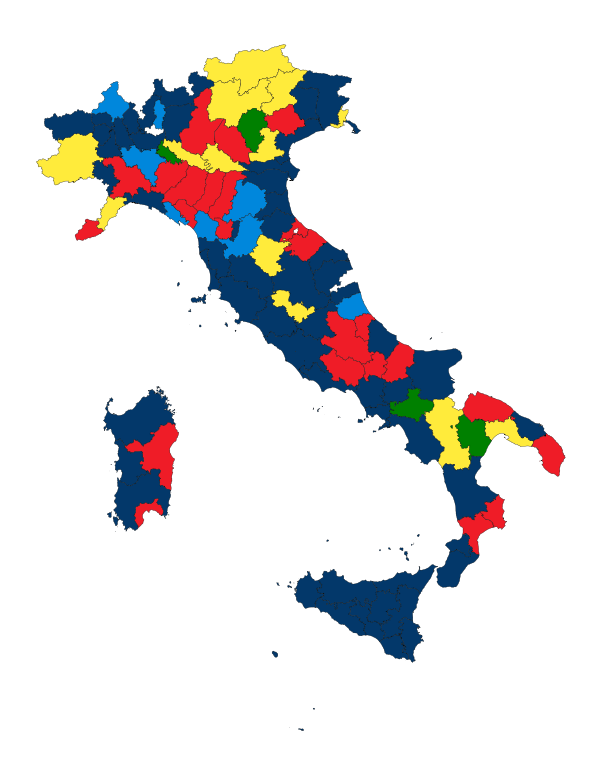

In [34]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df_dv[df_dv["rank"] == 1]
data_tmp = pd.merge(gdf, data_tmp, left_on="prov_istat_code", right_on="province_id")
data_tmp["color"] = data_tmp["candidate"].replace(colors)
data_tmp = gpd.GeoDataFrame(data_tmp)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

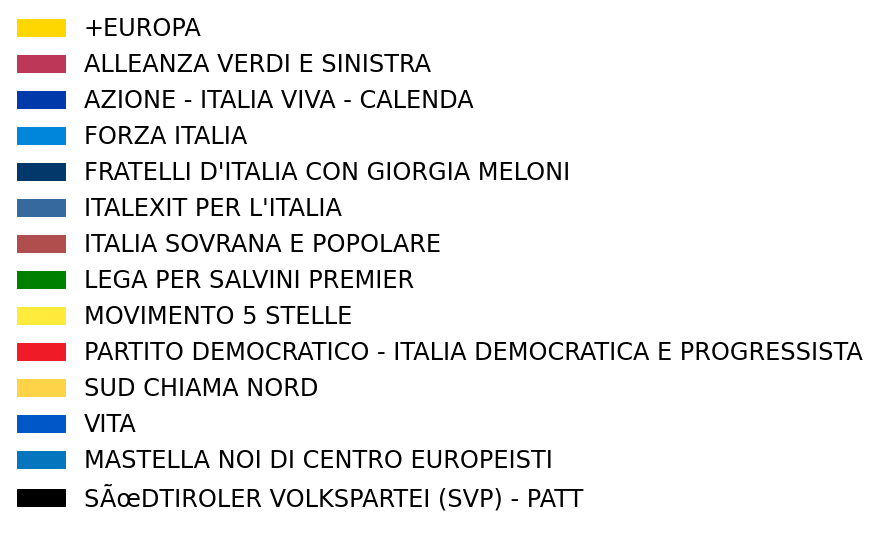

In [38]:
#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

for key in colors.keys():
    if key in df["candidate"].unique():
        value = colors[key]
        if value != "#FFFFFF":
            patch = mpatches.Patch(color=value, label=key)
            handles.append(patch) 
        
legend = plt.legend(handles=handles, loc='lower center', fontsize=24, frameon=False, ncol=1)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.axis("off")
# export_legend(legend)
# plt.show()
legend

In [25]:
set(gdf.prov_istat_code.unique()) - set(dd.province_id.unique())

{'004', '108', '109', '110'}

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(6.0319333570096205, 19.115069610626986, 34.91378734496388, 47.671688337009705)

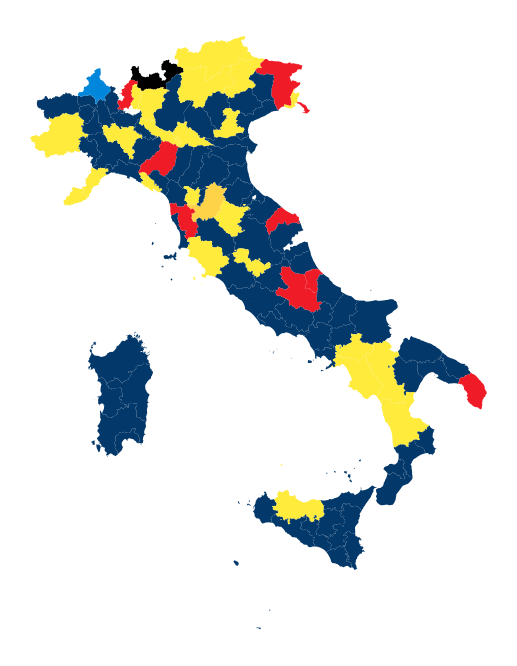

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))

data = pd.merge(gdf, dd, left_on="prov_istat_code", right_on="province_id")
data = data[data["rank"] == 1].copy()
data["color"] = data["candidate"].replace(colors)

data.plot(
    column="candidate",
    color=data["color"],
    legend=True,
    ax=ax
)

plt.axis("off")